
## 12. Дифференциальные уравнения. Робин Гуд

Робин Гуд бросает камень с привязанным к нему письмом через бойницу крепостной стены в открытое окно, стоящего за ней замка:

Смоделируйте полет камня с помощью функции integrate.solve_ivp. Рассмотрите следующие события (events):

1. камень упал на землю, не долетев до окна (либо до, либо после стены);
1. камень не попал в бойницу (ударился о стену);
1. камень застрял в бойнице (стукнулся о «пол» или «потолок» бойницы и упал внутри нее);
1. камень стукнулся о стену замка (не попав в окно);
1. камень попал в окно (для простоты считаем, что и крепостная стена, и замок очень высокие и сверху через них камень перебросить нельзя). 
При наступлении каждого из этих событий дальнейшее интегрирование прекращаются.

Написать функцию, на вход которой подаются:

    параметры: масса камня, расстояние от Робин Гуда до стены, толщину стены (равную длине бойницы), расстояние от земли до бойницы и высоту бойницы, расстояние от стены до замка, расстояние от земли до окна и высоту окна,

    начальные условия: угол броска и начальную скорость камня.

Программа должна отображать «вид сбоку» (многоугольники можно нарисовать с помощью функций matplotlib.patches.Patch) и траекторию полета.'''


In [122]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import integrate
import matplotlib.patches as patches

In [123]:
dist_RobWall = 10
width_Wall = 1
dist_floorHole = 5
hole_height = 1
dist_WallCastle = 5
dist_floorWindow = 3
window_height = 1

v0 = 10
alpha = np.pi / 4

In [124]:
# Дифференциальные уравнения для горизонтального и вертикального перемещения
def dif_y (t, y):
    return v0 * np.sin(alpha) - 9.8 * t
def dif_x (t, x):
    return v0 * np.cos(alpha)
# Событие пересечения с землей
def event_ground (t, y):
    return y
# Событие вылета за стену замка
def event_outOfPlace (t, x):
    return x - np.array(dist_RobWall + 2 * width_Wall + dist_WallCastle)
# Вылеты за пределы стены должны завершать интегрирование уравнений
event_ground.terminal = True
event_outOfPlace.terminal = True

# Остальные события не завершают интегрирование, 
# так как они могут достигнуть нужной координаты по одной оси,
# но не пересечь нужные координаты второй оси

# События касания нижней и верхней части бойницы
def eventY_hitWall_0 (t, y):
    return y - np.array(dist_floorHole)
def eventY_hitWall_1 (t, y):
    return y - np.array(6)
# События касания нижней и верхней части окна
def eventY_hitCastle_0 (t, y):
    return y - np.array(dist_floorWindow)
def eventY_hitCastle_1 (t, y):
    return y - np.array(dist_floorWindow + window_height)
# Событие касания стены
def eventX_hitWall (t, x):
    return x - np.array(dist_RobWall)
# Событие касания замка
def eventX_hitCastle (t, x):
    return x - np.array(dist_RobWall + width_Wall + dist_WallCastle)

In [125]:
def Robin( _v0, _alpha ):
    v0 = _v0
    alpha = _alpha
    wall_bottom = patches.Rectangle((dist_RobWall, 0), 
                                    width_Wall, dist_floorHole,
                                    edgecolor='black', facecolor='MidnightBlue')
    wall_top = patches.Rectangle((dist_RobWall, dist_floorHole + hole_height),
                                    width_Wall, dist_floorHole,
                                    edgecolor='black', facecolor='MidnightBlue')
    castle_bottom = patches.Rectangle((dist_RobWall + width_Wall + dist_WallCastle, 0),
                                    width_Wall, dist_floorWindow,
                                    edgecolor='black', facecolor='MidnightBlue')
    castle_top = patches.Rectangle((dist_RobWall + width_Wall + dist_WallCastle, dist_floorWindow + window_height),
                                    width_Wall, dist_floorWindow,
                                    edgecolor='black', facecolor='MidnightBlue')
    Robin = patches.Rectangle((-0.3, 0), 0.3, 1.8, edgecolor='Black', facecolor='MediumPurple')
    
    ground = patches.Rectangle((-3, -1), dist_RobWall + dist_WallCastle + width_Wall * 2 + 6, 1,
                               edgecolor='Black', facecolor='DarkGreen')
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot()
    
    ax.add_patch(wall_bottom)
    ax.add_patch(wall_top)
    ax.add_patch(castle_bottom)
    ax.add_patch(castle_top)
    ax.add_patch(Robin)
    ax.add_patch(ground)

    y0 = [1.8]
    x0 = [0]
    
    solY = integrate.solve_ivp(dif_y, [0, np.Inf], y0,
                               events = [event_ground, eventY_hitWall_0, eventY_hitWall_1, eventY_hitCastle_0, eventY_hitCastle_1],
                               dense_output=True)
    solX = integrate.solve_ivp(dif_x, [0, np.Inf], x0,
                               events = [event_outOfPlace, eventX_hitWall, eventX_hitCastle],
                               dense_output=True)
    
    events = []
    events.append(solY.t_events[0][0])
    events.append(solX.t_events[0][0])
    
    # Событие столкновения со стеной
    t1 = solX.t_events[1][0]
    if (0 <= solY.sol(t1) <= dist_floorHole):
        events.append(t1)
    elif (dist_floorHole + hole_height <= solY.sol(t1) <= 2 * dist_floorHole + hole_height):
        events.append(t1)
    # Событие столкновения со стеной замка
    t1 = solX.t_events[2][0]
    if (0 <= solY.sol(t1) <= dist_floorWindow):
        events.append(t1)
    elif (dist_floorWindow + window_height <= solY.sol(t1) <= 2 * dist_floorWindow + window_height):
        events.append(t1)
    # Событие касания внутренней части бойницы
    for e in solY.t_events[1:3]:
        for t1 in e:
            if (dist_RobWall <= solX.sol(t1) <= dist_RobWall + width_Wall):
                events.append(t1)
    # Событие касания внутренней части окна
    for e in solY.t_events[3:]:
        for t1 in e:
            if (dist_RobWall + width_Wall + dist_WallCastle <= solX.sol(t1) 
                and solX.sol(t1) <= dist_RobWall + 2 * width_Wall + dist_WallCastle):
                events.append(t1)
    t_end = min(events)
    
    t = np.linspace(0, t_end, 100)
    
    x = solX.sol(t)[0]
    y = solY.sol(t)[0]

    ax.plot(x, y, color=(0,0,0))
    plt.show()


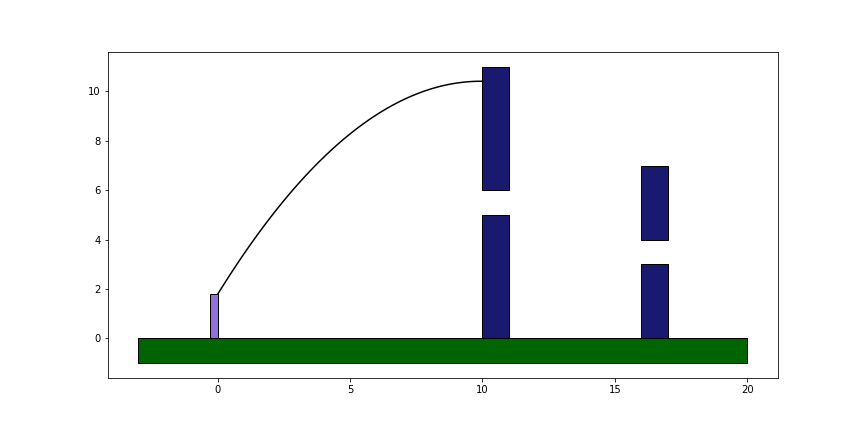

<Figure size 864x432 with 0 Axes>

In [126]:
v0 = 15
alpha = np.pi/3
Robin(v0, alpha)

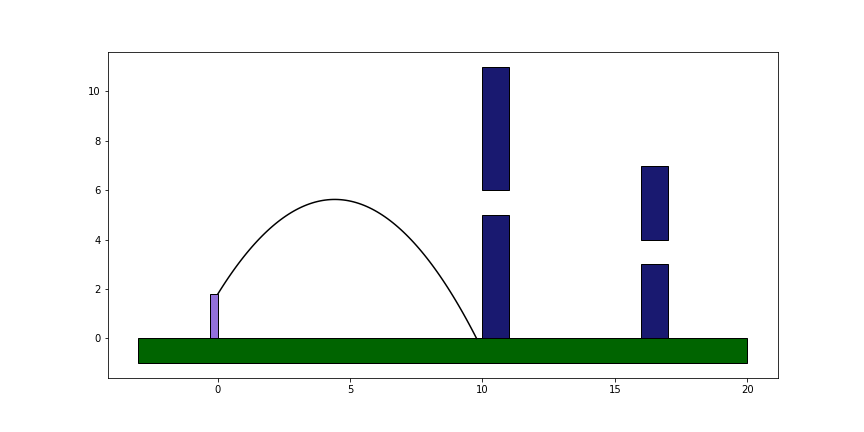

<Figure size 864x432 with 0 Axes>

In [127]:
v0 = 10
alpha = np.pi/3
Robin(v0, alpha)

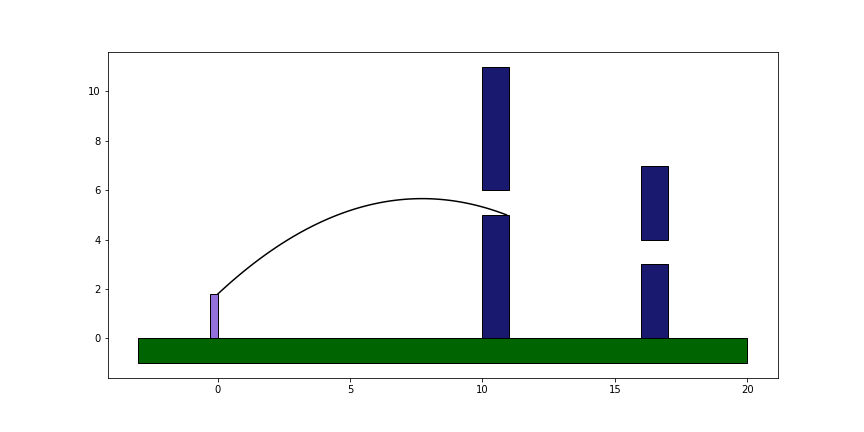

<Figure size 864x432 with 0 Axes>

In [128]:
v0 = 12.3
alpha = np.pi/4
Robin(v0, alpha)

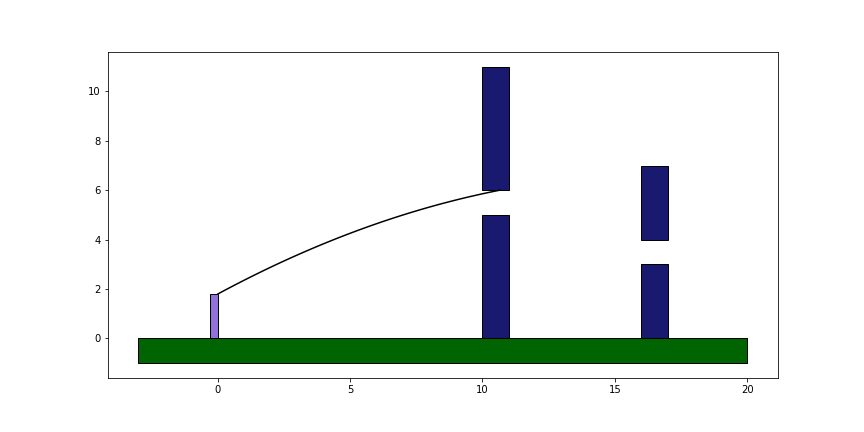

<Figure size 864x432 with 0 Axes>

In [129]:
v0 = 19.5
alpha = np.pi/6
Robin(v0, alpha)

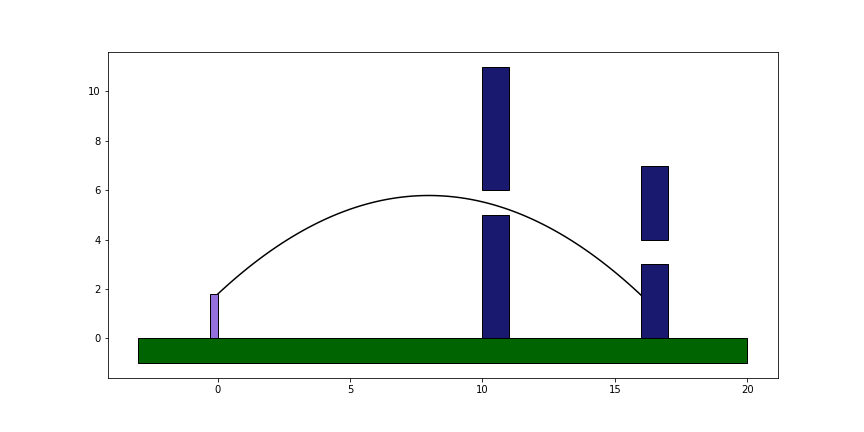

<Figure size 864x432 with 0 Axes>

In [130]:
v0 = 12.5
alpha = np.pi/4
Robin(v0, alpha)

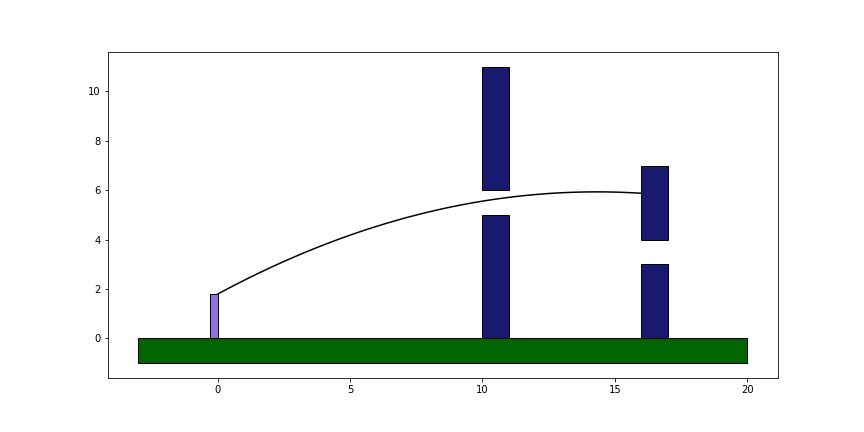

<Figure size 864x432 with 0 Axes>

In [131]:
v0 = 18
alpha = np.pi/6
Robin(v0, alpha)

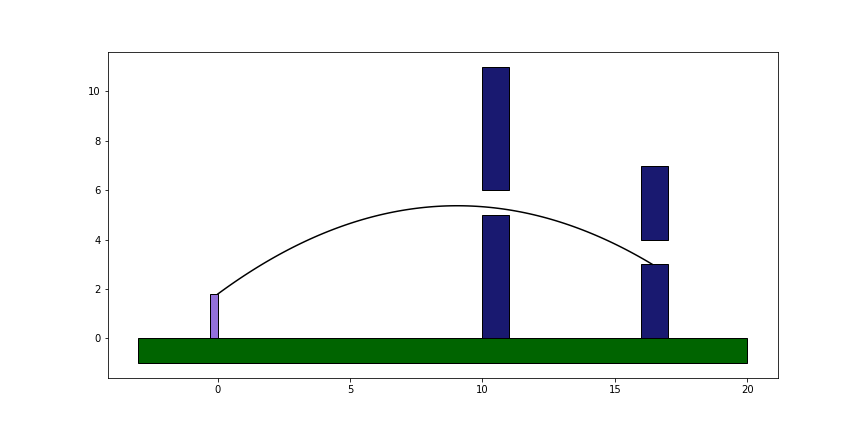

<Figure size 864x432 with 0 Axes>

In [137]:
v0 = 13.5
alpha = np.pi/4.7
Robin(v0, alpha)